In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model, sklearn.calibration

import loader
from models import DummyEstimator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.5  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

max_workers = 32

data_dir = "data/communities"

In [2]:
## Load UCI Communities and Crime dataset
dataset_name = "Communities"

(inputs_df, labels, label_names, groups,
 group_names) = loader.load_communities(data_dir, n_classes=5)
inputs_u_df = loader.load_communities(data_dir,
                                      n_classes=5,
                                      remove_sensitive_attr=True)[0]

display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32)
inputs_u = np.array(inputs_u_df.values, dtype=np.float32)

Group,asian,black,hispanic,white
Target,,,,
"(-0.001, 0.2]",432,218,159,379
"(0.2, 0.4]",88,179,140,25
"(0.4, 0.6]",18,119,50,5
"(0.6, 0.8]",16,59,19,1
"(0.8, 1.0]",8,65,13,1


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

In [4]:
# Calibrator definition

calibrator_factory = partial(sklearn.calibration.CalibratedClassifierCV,
                             estimator=DummyEstimator(n_classes),
                             cv='prefit',
                             method='sigmoid')

## Logistic regression

In [5]:
model_name = 'log. reg.'

# Train attribute aware p(Y | X, A) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))

Binned ECE of attribute aware predictor: 1.150329594595177


In [6]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_a_ = np.eye(n_groups)[groups_]

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_y_x': probas_y_,
    'p_a_x': probas_a_,
    'max_workers': max_workers,
}

  0%|                                                    | 0/70 [00:00<?, ?it/s]

 46%|███████████████████▋                       | 32/70 [00:00<00:00, 48.58it/s]

 91%|███████████████████████████████████████▎   | 64/70 [00:03<00:00, 16.68it/s]

100%|███████████████████████████████████████████| 70/70 [00:03<00:00, 20.22it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 5181.72it/s]

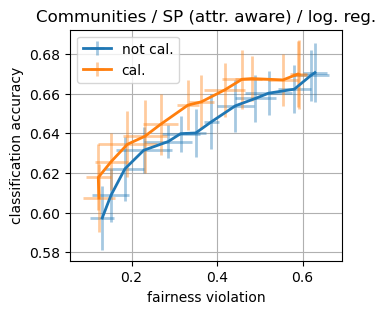

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.670569  0.014721  0.629017  0.028296
0.600  0.669231  0.012921  0.620131  0.042228
0.550  0.662207  0.012231  0.580662  0.038910
0.500  0.660201  0.011118  0.520777  0.054837
0.450  0.657525  0.011907  0.489495  0.047811
0.400  0.653846  0.013220  0.442981  0.042819
0.350  0.645819  0.013860  0.387042  0.017857
0.300  0.640134  0.011907  0.350066  0.023867
0.250  0.639799  0.009052  0.314901  0.044175
0.200  0.635786  0.008477  0.285389  0.056294
0.150  0.631438  0.011682  0.228619  0.065728
0.100  0.622074  0.016213  0.184502  0.045812
0.050  0.608696  0.013326  0.151829  0.043234
0.001  0.597324  0.016273  0.131500  0.027515

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.669565  0.017322  0.592394  0.017226
0.600  0.669900  0.016495  0.589737  0.019704
0.550  0.666890  0.012975  0.554391  0.034233
0.500  0.667559  0.011428  0.481446  0.040154
0.450  0.667224  0.014863  0.458527  0.047155
0.400  0.661873  0.013451  0.418176  0.048063
0.350  0.655853  0.013503  0.363425  0.029731
0.300  0.654181  0.012424  0.331995  0.025152
0.250  0.644482  0.015262  0.267805  0.040731
0.200  0.638462  0.018334  0.231065  0.051787
0.150  0.634448  0.016706  0.190445  0.070017
0.100  0.625753  0.014405  0.152519  0.038487
0.050  0.617726  0.016622  0.122176  0.029820
0.001  0.607358  0.017274  0.123843  0.038289

In [7]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15,
                0.1, 0.05, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_y_factory=calibrator_factory,
    **postprocess_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

## Gradient boosting decision tree

In [8]:
model_name = 'GBDT'

# Train attribute aware p(Y | X, A) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain, verbosity=-1)
predictor_y.fit(inputs_pretrain, labels_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))

Binned ECE of attribute aware predictor: 1.4295785235042526


In [9]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_a_ = np.eye(n_groups)[groups_]

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_y_x': probas_y_,
    'p_a_x': probas_a_,
    'max_workers': max_workers,
}

  0%|                                                    | 0/65 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 6298.19it/s]

  0%|                                                    | 0/65 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 4097.17it/s]

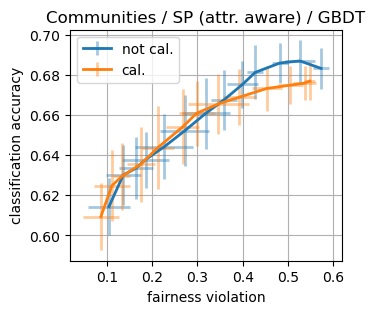

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.683278  0.010213  0.572662  0.018183
0.550  0.686957  0.010335  0.526163  0.032653
0.500  0.685953  0.009992  0.482198  0.018730
0.450  0.681271  0.013513  0.427607  0.017649
0.400  0.675251  0.011610  0.399205  0.034094
0.350  0.667559  0.015115  0.358460  0.028288
0.300  0.660870  0.017753  0.318377  0.052784
0.250  0.652174  0.017658  0.271855  0.054557
0.200  0.644147  0.016187  0.226352  0.063928
0.150  0.637793  0.013971  0.185361  0.052536
0.100  0.633445  0.015526  0.164009  0.038328
0.050  0.630100  0.015115  0.136048  0.038798
0.001  0.614381  0.014366  0.104583  0.046228

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.676923  0.009635  0.547963  0.012052
0.550  0.675920  0.008560  0.536361  0.024836
0.500  0.674916  0.009356  0.505383  0.027707
0.450  0.673244  0.011440  0.453020  0.033715
0.400  0.668896  0.013840  0.392451  0.036674
0.350  0.665552  0.015004  0.346032  0.067037
0.300  0.660870  0.016273  0.298088  0.039952
0.250  0.654181  0.018748  0.267706  0.036693
0.200  0.643813  0.020786  0.212664  0.034849
0.150  0.635452  0.018659  0.174564  0.030954
0.100  0.629431  0.016831  0.132897  0.018657
0.050  0.624749  0.017721  0.110881  0.039193
0.001  0.609365  0.016747  0.086734  0.040411

In [10]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                0.05, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_y_factory=calibrator_factory,
    **postprocess_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)